In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model("models/best_model.h5")

# Label map: Update this with actual Devanagari characters
label_map = {i: f'Char_{i}' for i in range(46)}  # Replace with actual label -> character map


In [22]:
def segment_characters(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 140, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Remove Shirorekha
    cleaned = remove_shirorekha(thresh)

    # Morphological operations to reduce small artifacts
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=1)

    # Find contours
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    char_regions = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = cv2.contourArea(cnt)
        aspect_ratio = w / float(h)

        # Filters to avoid noise and over-segmented parts
        if area < 50 or w < 5 or h < 10:
            continue
        if aspect_ratio < 0.2 or aspect_ratio > 5:
            continue

        roi = gray[y:y + h, x:x + w]
        resized = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
        padded = cv2.copyMakeBorder(resized, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=255)
        padded = cv2.bitwise_not(padded)
        char_regions.append((x, padded))

    char_regions.sort(key=lambda x: x[0])
    return [img for _, img in char_regions]


In [23]:
def predict_characters(char_imgs):
    predictions = []
    for char in char_imgs:
        img = char.astype("float32") / 255.0
        img = np.expand_dims(img, axis=-1)
        img = np.expand_dims(img, axis=0)
        pred = model.predict(img, verbose=0)
        pred_label = label_map[np.argmax(pred)]
        predictions.append(pred_label)
    return predictions


In [24]:
def show_word_and_segments(word_img_path):
    img = cv2.imread(word_img_path)
    char_imgs = segment_characters(img)
    predictions = predict_characters(char_imgs)

    fig, axs = plt.subplots(1, len(char_imgs) + 1, figsize=(18, 4))
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].axis("off")
    axs[0].set_title("Input Word")

    for i, char in enumerate(char_imgs):
        axs[i + 1].imshow(char, cmap="gray")
        axs[i + 1].axis("off")
        axs[i + 1].set_title(predictions[i])

    plt.tight_layout()
    plt.show()


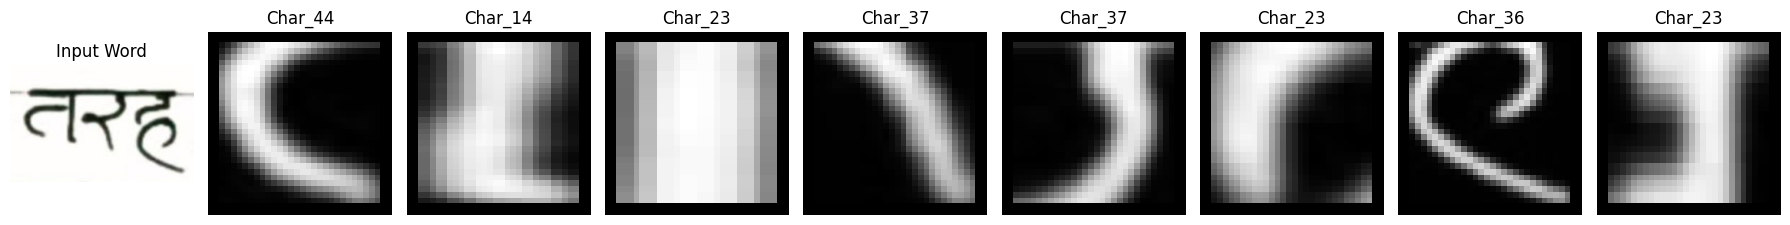

In [28]:

word_img = "./word_samples/example2.png"
show_word_and_segments(word_img)  


In [29]:
def predict_word(char_images):
    predicted_word = ""
    for i, char_img in enumerate(char_images):
        img = char_img.astype("float32") / 255.0
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        img = np.expand_dims(img, axis=-1)  # Add channel dimension (if grayscale)

        pred = model.predict(img, verbose=0)
        pred_class = np.argmax(pred)
        predicted_char = label_map.get(pred_class, "?")
        predicted_word += predicted_char

    return predicted_word

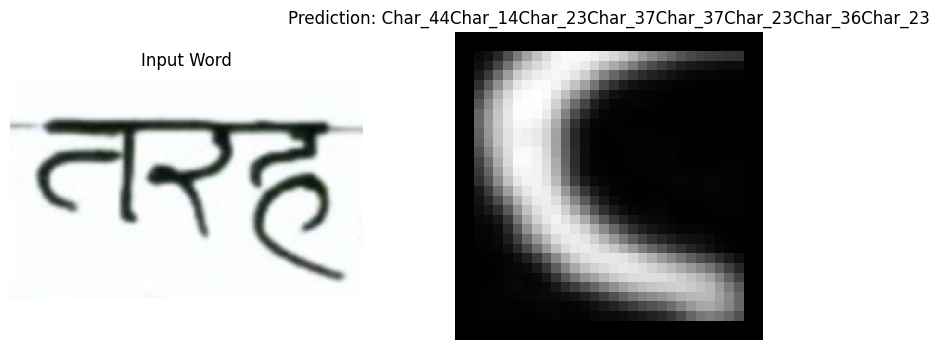

In [34]:
# Load word image
img = cv2.imread("./word_samples/example2.png")  # Or use cv2.imread("your_path.png")
word_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

# Segment characters
char_imgs = segment_characters(word_img)

# Predict word
predicted_word = predict_word(char_imgs)

# Display input image and prediction
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(word_img, cv2.COLOR_BGR2RGB))
plt.title("Input Word")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(char_imgs[0], cmap="gray")  # Just show first char
plt.title(f"Prediction: {predicted_word}")
plt.axis("off")
plt.show()
